# Visualization of difference matrices
This notebook illustrates the different ways to calculate the change between to Hi-C contact matrices. 

In [1]:
import sys
sys.path.insert(1, '/home/elinfi/MasterCode/clustering/class/')

In [2]:
import cooltools.lib.plotting

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pretty_plotting as pplot
import plot_functions as plotf

from data_preparation import DataPreparation
from dissimilarity_matrix import DissimilarityMatrix
from mid_point_log_norm import MidPointLogNorm


In [3]:
# globally set font sizes
pplot.font_size(16, 20, 24)

In the comparison I use the merged wild type and cancer data. The Hi-C data is balanced using the built in ICE method in the cooler package. 

In [4]:
# get path to multi resolution hic data
path_wt = '/home/elinfi/coolers/HiC_wt_merged.mcool'
path_cancer = '/home/elinfi/coolers/HiC_cancer_merged.mcool'

resolution = 32000
#region = 'chr4:4M-10M' # region of genome
#region = 'chr19:13807597-16807597'
#region = 'chr14:33408661-36408661'
region = 'chr6:124121218-127121218'
balance = True

# create objects of class
wt = DataPreparation(path_wt, resolution, region, balance)
cancer = DataPreparation(path_cancer, resolution, region, balance)

# get the matrix size
print(f"Matrix size: {wt.matrix.shape}")

Matrix size: (95, 95)


To start with I plot the two created contact matrices for the given resolution and region.

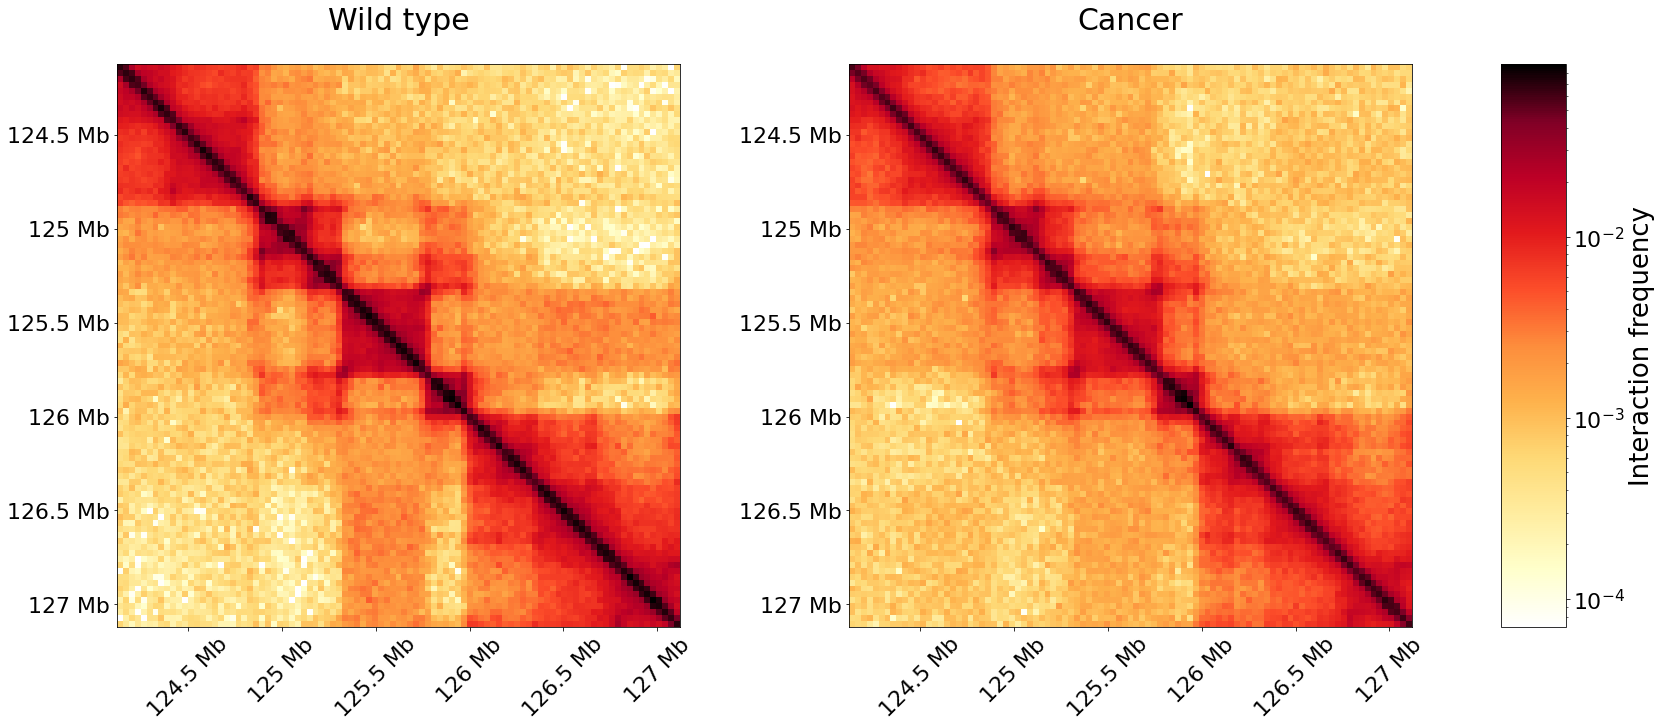

In [5]:
# globally set font sizes
pplot.font_size(22, 26, 30)

fig, axs = plt.subplots(figsize=(23, 10),
                        nrows=1,
                        ncols=2,
                        sharex=True, sharey=False,
                        constrained_layout=True)

norm = mpl.colors.LogNorm()
extent = pplot.region2extent(region)

ax = axs[0]
im = ax.matshow(wt.matrix,
                norm=norm,
                cmap='fall',
                alpha=1,
                extent=extent)
#plt.colorbar(im, fraction=0.046, pad=0.04, label='Interaction frequency', ax=ax)
#ax.grid(visible=True)
ax.set(title='Wild type')
pplot.format_ticks(ax)

ax = axs[1]
im = ax.matshow(cancer.matrix,
                norm=norm,
                cmap='fall',
                alpha=1,
                extent=extent)
ax.set(title='Cancer')
pplot.format_ticks(ax)
fig.colorbar(im, fraction=0.05, pad=0.1,label='Interaction frequency', ax=ax)

plt.savefig(f'../../Figures/Differences/{region}_comparison.png')

## Subtraction
Calculate the difference between the two interaction matrices by subtraction and visualize it.

In [6]:
subtract_diff = wt.subtract(cancer)

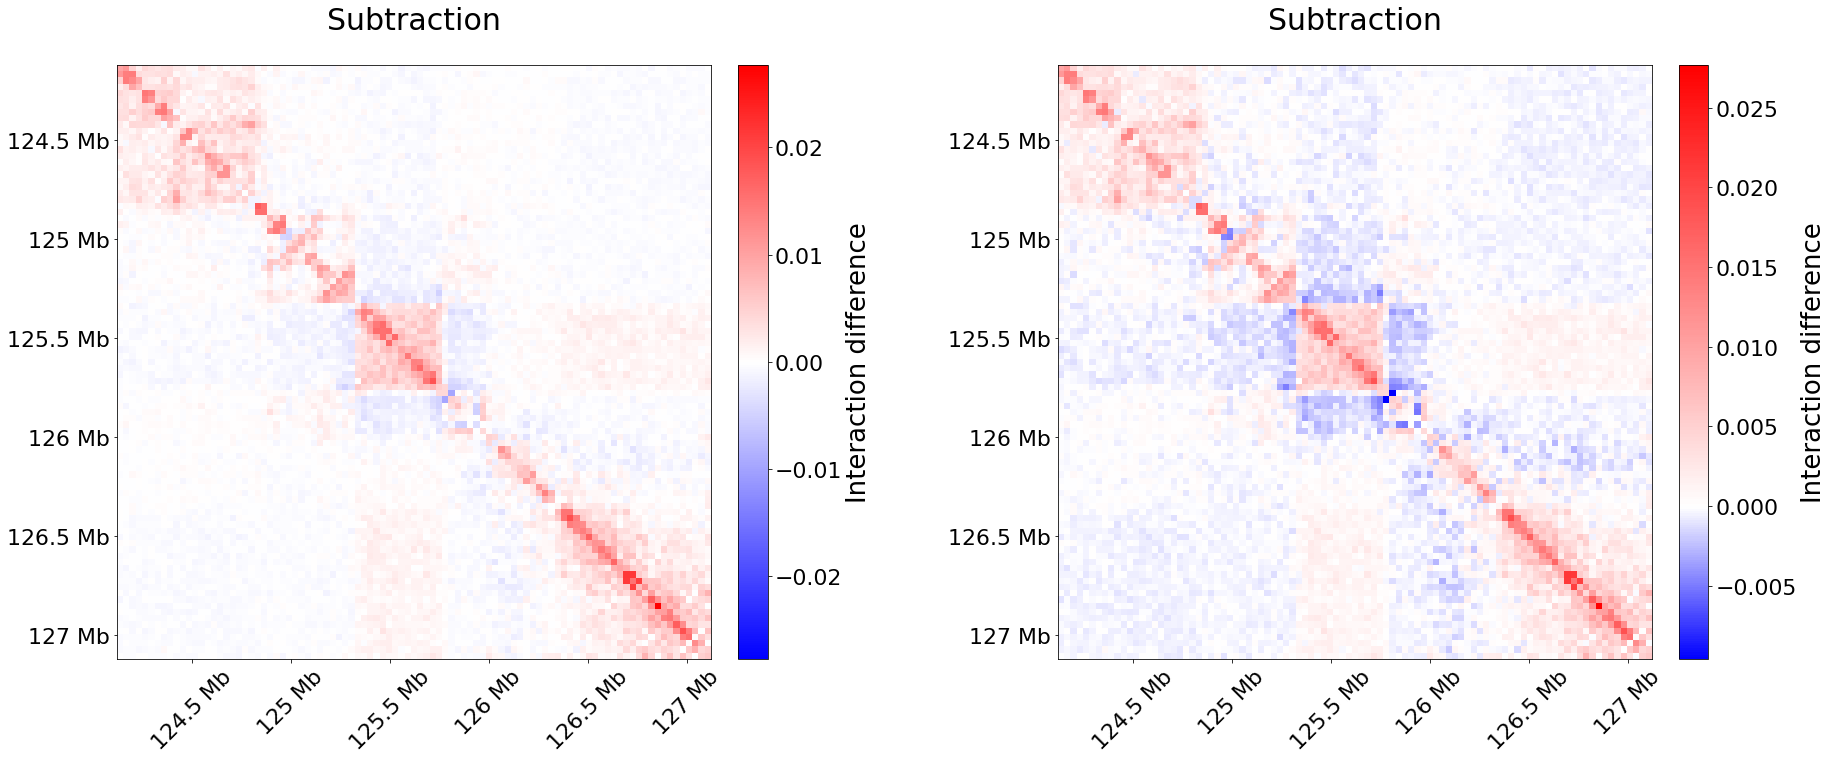

In [7]:
plotf.sub_colorbars(subtract_diff, region, 'test.png',
                    figsize=(28, 11),
                    sharex=True, sharey=False,
                    constrained_layout=False)

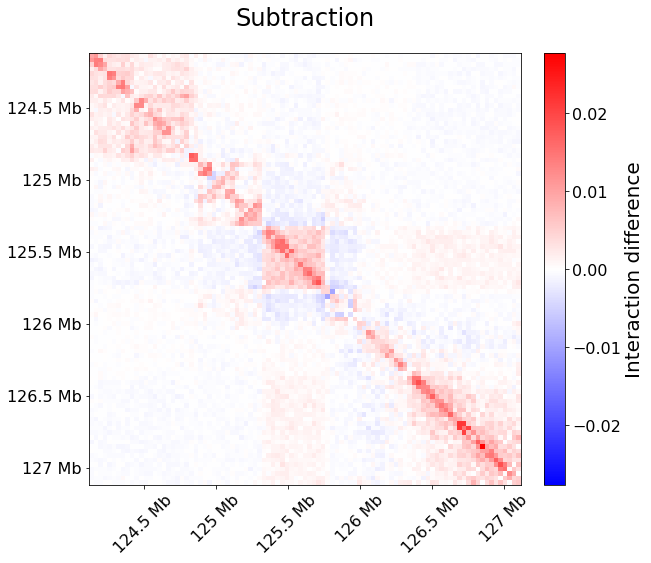

In [23]:
plotf.sub_vmax(subtract_diff, region, 'sub_vmax.png',
               figsize=(9, 8),
               left=0, bottom=0.15, right=0.88, top=0.9)

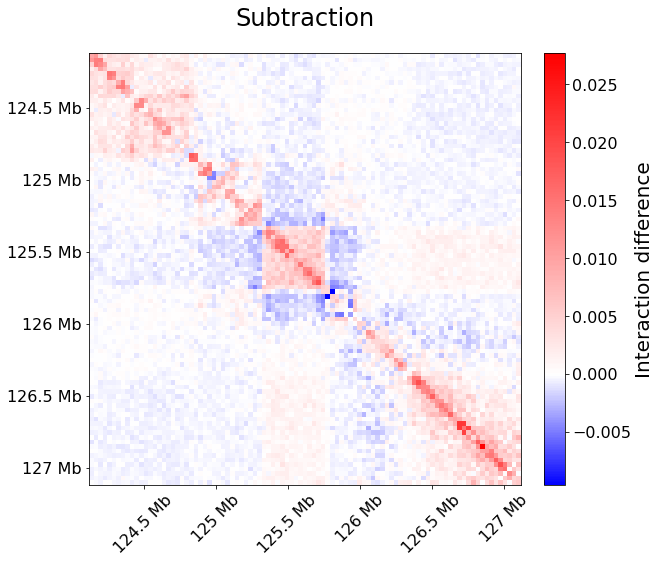

In [25]:
plotf.sub_norm(subtract_diff, region, 'sub_norm.png',
               figsize=(9, 8),
               left=0, bottom=0.15, right=0.87, top=0.9)

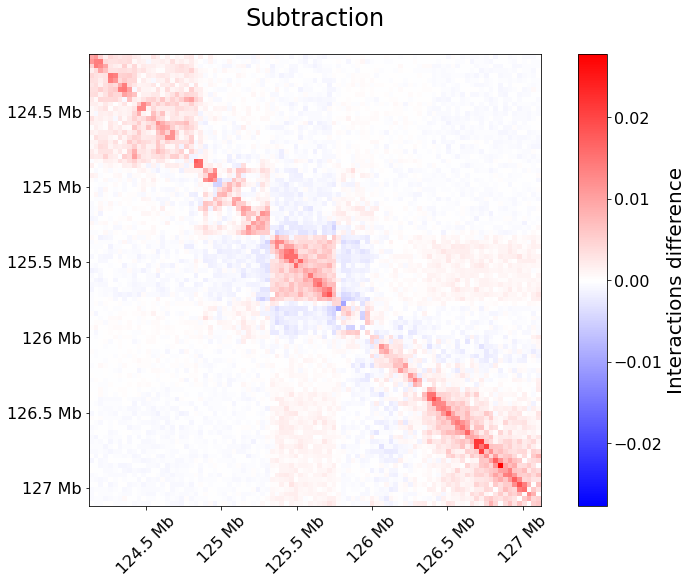

In [10]:
pplot.font_size(16, 20, 24)
f, axs = plt.subplots(figsize=(10, 8),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False,
                      constrained_layout=True)
ax = axs
vmax = np.nanmax(abs(subtract_diff))
extent = pplot.region2extent(region)

im = ax.matshow(subtract_diff,
                vmax=vmax,
                vmin=-vmax,
                #norm=norm,
                cmap='bwr',
                extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title='Subtraction')
pplot.format_ticks(ax)
plt.savefig(f'../../Figures/Differences/{region}_subtraction_vmax_vmin.png')

White indicates that the interaction frequency is the same in both the wild type and the cancer data. Red colors indicates higher interaction frequency in the wild type data, whereas blue indicates higher interaction frequency in the cancer data.

## HiGlass divide by
Calculate the difference between the two interaction matrices by division and visualize it.

In [11]:
division_diff = wt.higlass_ratio(cancer)
division_diff_masked = np.ma.masked_invalid(division_diff)

In [12]:
#norm = TwoSlopeLogNorm(vcenter=1)
#norm = mpl.colors.LogNorm()
norm=MidPointLogNorm(midpoint=1)
def tick(y, pos):
    return r'$e^{:.0f}$'.format(np.log(y))

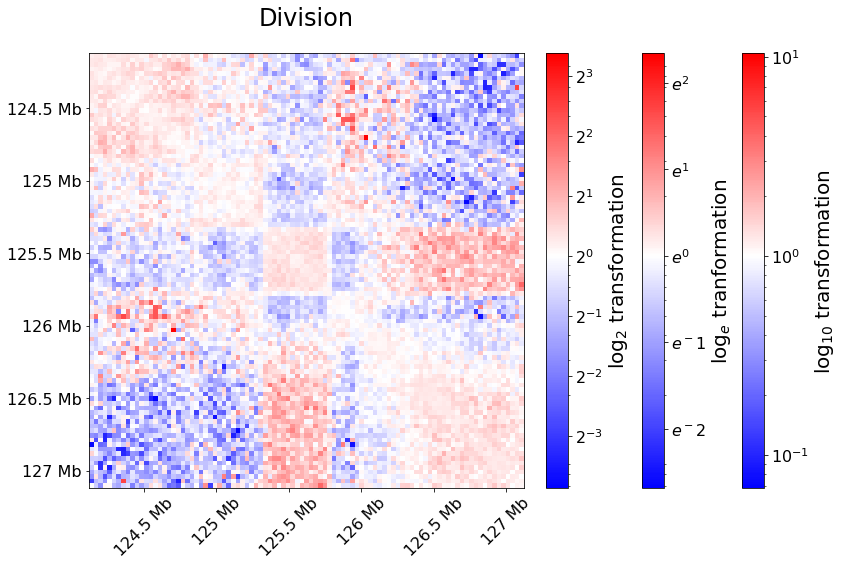

In [13]:
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator, LogFormatterSciNotation, FuncFormatter

pplot.font_size(16, 20, 24)

f, axs = plt.subplots(figsize=(14, 8),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)

locator10 = LogLocator(base=10)
formatter10 = LogFormatterSciNotation(base=10)

locator2 = LogLocator(base=2)
formatter2 = LogFormatterSciNotation(base=2)

locator_e = LogLocator(base=np.e)
#formatter_e = LogFormatterSciNotation(base=np.e)
formatter_e = FuncFormatter(tick)
#norm = mcolors.LogNorm()

extent = pplot.region2extent(region)

ax = axs
im = ax.matshow(division_diff_masked,
                norm=norm,
                cmap='bwr',
                extent=extent)
plt.colorbar(im, pad=0.001, label='$\log_{10}$ transformation', ax=ax,
             ticks=locator10, format=formatter10)
plt.colorbar(im, pad=0.02, label='$\log_e$ tranformation', ax=ax,
             ticks=locator_e, format=formatter_e)
plt.colorbar(im, pad=0.04, label='$\log_2$ transformation', ax=ax,
             ticks=locator2, format=formatter2)
#ax.set(title="Division", fontname='georgia')
ax.set_title('Division')
pplot.format_ticks(ax)
plt.savefig(f'../../Figures/Differences/{region}_div_logs.png')

The base of the logarithmical transformation does not change the coloring, only the values and the ticks of the color bar changes.

## Division with pseudocount
Calculate the difference between the two interaction matrices by division with a pseudocount added, and visualize it.

In [14]:
pseudo_1 = wt.divide_with_pseudocount(cancer, pseudocount=1)
pseudo_1_masked = np.ma.masked_invalid(pseudo_1)

pseudo_01 = wt.divide_with_pseudocount(cancer, pseudocount=0.1)
pseudo_01_masked = np.ma.masked_invalid(pseudo_01)

pseudo_001 = wt.divide_with_pseudocount(cancer, pseudocount=0.01)
pseudo_001_masked = np.ma.masked_invalid(pseudo_001)

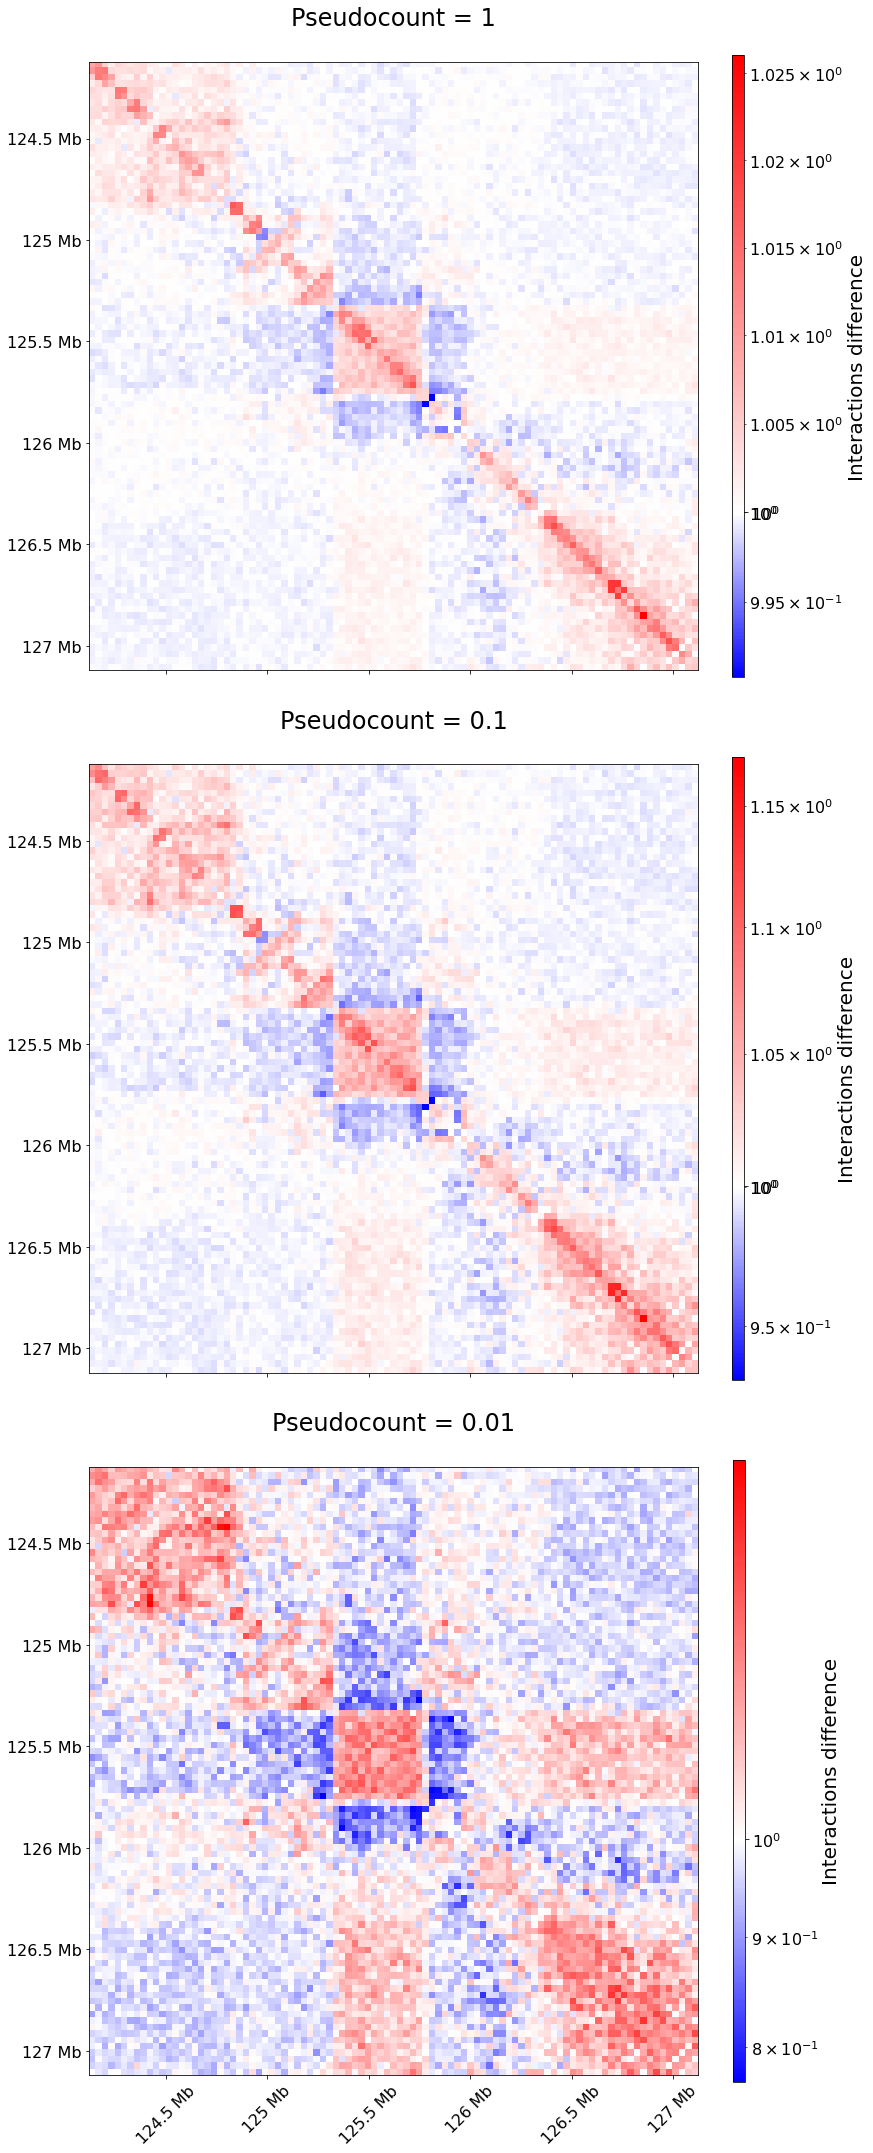

In [15]:
pplot.font_size(16, 20, 24)
f, axs = plt.subplots(figsize=(12, 30),
                      nrows=3,
                      ncols=1,
                      sharex=True, sharey=False,
                      constrained_layout=True)
extent = pplot.region2extent(region)

################################################################################

ax = axs[0]
norm = MidPointLogNorm(vmin=pseudo_1_masked.min(), vmax=pseudo_1_masked.max(), midpoint=1)

im = ax.matshow(pseudo_1_masked,
                norm=norm,
                cmap='bwr',
                extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title="Pseudocount = 1")
pplot.format_ticks(ax)

################################################################################

ax = axs[1]
norm = MidPointLogNorm(vmin=pseudo_01_masked.min(), vmax=pseudo_01_masked.max(), midpoint=1)

im = ax.matshow(pseudo_01_masked,
                norm=norm,
                cmap='bwr',
                extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title="Pseudocount = 0.1")
pplot.format_ticks(ax)

################################################################################

ax = axs[2]
norm = MidPointLogNorm(vmin=pseudo_001_masked.min(), vmax=pseudo_001_masked.max(), midpoint=1)

im = ax.matshow(pseudo_001_masked,
                norm=norm,
                cmap='bwr',
                extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title="Pseudocount = 0.01")
pplot.format_ticks(ax)
plt.savefig(f'../../Figures/Differences/{region}_div_pseudo.png')

## Relative difference
Calculate the relative difference between the two Hi-C contact matrices.

In [16]:
relative_diff = wt.relative_difference(cancer)

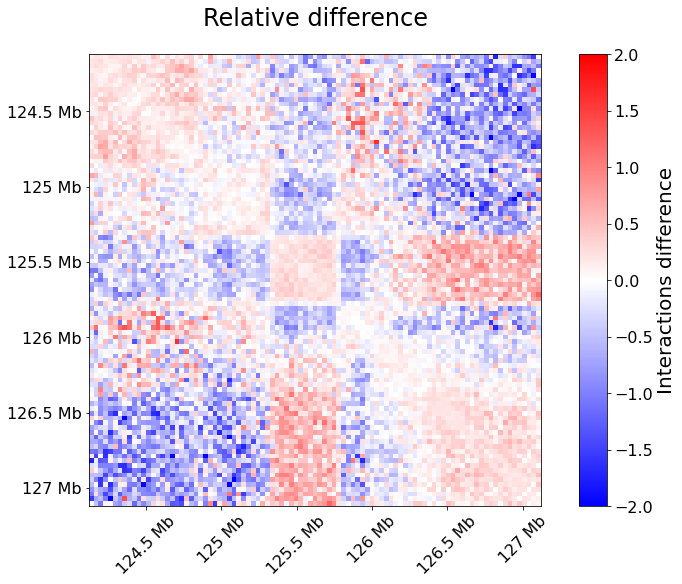

In [17]:
f, axs = plt.subplots(figsize=(10, 8),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False,
                      constrained_layout=True)
ax = axs
vmax = np.nanmax(abs(relative_diff))
extent = pplot.region2extent(region)

im = ax.matshow(relative_diff,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr',
                extent=extent)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title="Relative difference")
pplot.format_ticks(ax)
plt.savefig(f'../../Figures/Differences/{region}_reldiff.png')

White indicates that the interaction frequency is the same in both the wild type and the cancer data. Red colors indicates higher interaction frequency in the wild type data, whereas blue indicates higher interaction frequency in the cancer data.

# Save data

In [18]:
import os

PATH = '../../Datafiles/Differences'
np.save(os.path.join(PATH, f'{region}_wt.npy'), wt.matrix)
np.save(os.path.join(PATH, f'{region}_cancer.npy'), cancer.matrix)

np.save(os.path.join(PATH, f'{region}_sub.npy'), subtract_diff)

np.save(os.path.join(PATH, f'{region}_div.npy'), division_diff)

np.save(os.path.join(PATH, f'{region}_pseudo_1.npy'), pseudo_1)
np.save(os.path.join(PATH, f'{region}_pseudo_01.npy'), pseudo_01)
np.save(os.path.join(PATH, f'{region}_pseudo_001.npy'), pseudo_001)

np.save(os.path.join(PATH, f'{region}_rel.npy'), relative_diff)

<ipython-input-18-fc9752a327a5>:9: RuntimeWarning: divide by zero encountered in log10
  np.save(os.path.join(PATH, f'div_log_10_{region}.npy'), np.log10(division_diff))
<ipython-input-18-fc9752a327a5>:10: RuntimeWarning: divide by zero encountered in log2
  np.save(os.path.join(PATH, f'div_log_2_{region}.npy'), np.log2(division_diff))
<ipython-input-18-fc9752a327a5>:11: RuntimeWarning: divide by zero encountered in log
  np.save(os.path.join(PATH, f'div_log_e_{region}.npy'), np.log(division_diff))
